In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    make_scorer,
)

In [9]:
path = '../data/steel.csv'
data = pd.read_csv(path)
feature_cols = [
    "normalising_temperature",
    "tempering_temperature",
    "percent_silicon",
    "percent_chromium",
    "percent_copper",
    "percent_nickel",
    "percent_sulphur",
    "percent_carbon",
    "percent_manganese",
]

X = data[feature_cols]
y = data["tensile_strength"]

In [10]:
#scoring setup
mae_scorer = "neg_mean_absolute_error"

mape_scorer = make_scorer(
    mean_absolute_percentage_error,
    greater_is_better=False,
)

In [11]:
#baseline gb regressor
gbr_default = GradientBoostingRegressor(
    random_state=1,   #same as rf
)

#10-fold cv on baseline model
gbr_cv_default = cross_validate(
    gbr_default,
    X,
    y,
    cv=10,
    scoring={"mae": mae_scorer, "mape": mape_scorer},
    return_train_score=True,
)

#converting negative values
gbr_train_mae = -gbr_cv_default["train_mae"]
gbr_test_mae = -gbr_cv_default["test_mae"]
gbr_train_mape = -gbr_cv_default["train_mape"]
gbr_test_mape = -gbr_cv_default["test_mape"]

print("\n_____Default Hyperparameters (GradientBoostingRegressor)_____")
print(f"Mean TRAIN MAE  over 10 folds: {gbr_train_mae.mean():.3f}")
print(f"Mean TEST  MAE  over 10 folds: {gbr_test_mae.mean():.3f}")
print(f"Mean TRAIN MAPE over 10 folds: {gbr_train_mape.mean():.3f}")
print(f"Mean TEST  MAPE over 10 folds: {gbr_test_mape.mean():.3f}")


_____Default Hyperparameters (GradientBoostingRegressor)_____
Mean TRAIN MAE  over 10 folds: 12.490
Mean TEST  MAE  over 10 folds: 32.413
Mean TRAIN MAPE over 10 folds: 0.076
Mean TEST  MAPE over 10 folds: 0.194


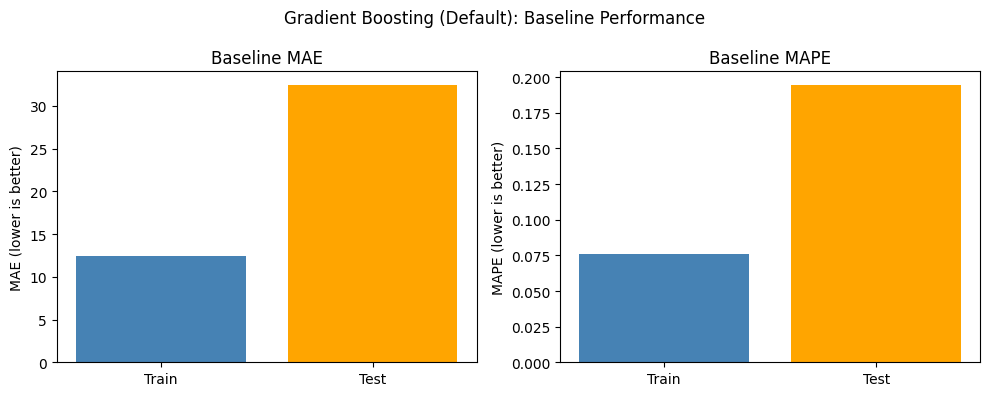

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#MAE plot
axes[0].bar(
    ["Train", "Test"],
    [gbr_train_mae.mean(), gbr_test_mae.mean()],
    color=["steelblue", "orange"]
)
axes[0].set_title("Baseline MAE")
axes[0].set_ylabel("MAE (lower is better)")

#MAPE plot
axes[1].bar(
    ["Train", "Test"],
    [gbr_train_mape.mean(), gbr_test_mape.mean()],
    color=["steelblue", "orange"]
)
axes[1].set_title("Baseline MAPE")
axes[1].set_ylabel("MAPE (lower is better)")

plt.suptitle("Gradient Boosting (Default): Baseline Performance")
plt.tight_layout()
plt.show()

In [37]:
gbr_base = GradientBoostingRegressor(
    random_state=1,
)

#hyperparam tuning
gbr_param_grid = {
    "n_estimators": [25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000],
    "learning_rate": [0.01, 0.02, 0.05, 0.075, 0.1, 0.15, 0.25, 0.4],
}

#grid search setup (10-fold cv, same as rf)
gbr_grid = GridSearchCV(
    estimator=gbr_base,
    param_grid=gbr_param_grid,
    cv=10,
    scoring=mae_scorer,
    return_train_score=True,
    n_jobs=-1,
)

#run hyperparam search
gbr_grid.fit(X, y)

#print best results
print("\n_____Best hyperparameters (GradientBoostingRegressor)_____")
print(gbr_grid.best_params_)
print(f"Best mean CV MAE (negative): {gbr_grid.best_score_:.3f}")
print(f"Best mean CV MAE (positive): {-gbr_grid.best_score_:.3f}")


_____Best hyperparameters (GradientBoostingRegressor)_____
{'learning_rate': 0.075, 'n_estimators': 950}
Best mean CV MAE (negative): -31.030
Best mean CV MAE (positive): 31.030


In [38]:
#dataframe of all results (for plots)
gbr_cv_df = pd.DataFrame(gbr_grid.cv_results_)

#showing useful columns sorted by performance
cols_to_show = [
    "param_n_estimators",
    "param_learning_rate",
    "mean_train_score",
    "mean_test_score",
]

print("\n_____Grid Search Results (GBR, MAE)_____")
print(gbr_cv_df[cols_to_show].sort_values("mean_test_score", ascending=False))


_____Grid Search Results (GBR, MAE)_____
     param_n_estimators  param_learning_rate  mean_train_score  \
82                  950                0.075         -2.725057   
100                 800                0.100         -2.276810   
101                 850                0.100         -2.072136   
83                 1000                0.075         -2.545555   
81                  900                0.075         -2.931985   
..                  ...                  ...               ...   
2                   100                0.010        -44.053687   
22                   50                0.020        -43.982130   
1                    50                0.010        -55.464006   
21                   25                0.020        -55.411810   
0                    25                0.010        -63.186069   

     mean_test_score  
82        -31.030327  
100       -31.036383  
101       -31.049379  
83        -31.049624  
81        -31.049962  
..               ...  
2   

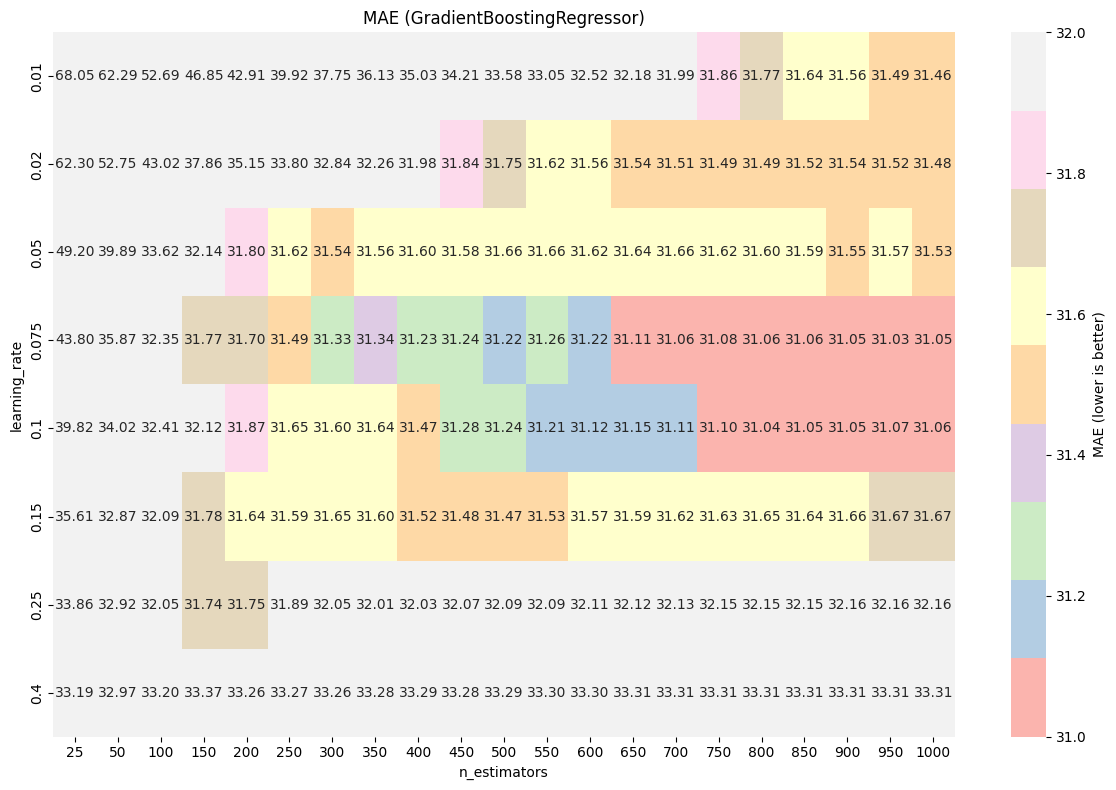

In [43]:
#converting to positive
gbr_cv_df["test_MAE"] = -gbr_cv_df["mean_test_score"]

#pivot table for heatmap
gbr_heatmap = gbr_cv_df.pivot_table(
    values="test_MAE",
    index="param_learning_rate",
    columns="param_n_estimators",
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    gbr_heatmap,
    annot=True,
    fmt=".2f",
    cmap="Pastel1",
    #for better colour spread
    vmin=31,
    vmax=32,
    cbar_kws={"label": "MAE (lower is better)"},
)
plt.title("MAE (GradientBoostingRegressor)")
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.tight_layout()
plt.show()

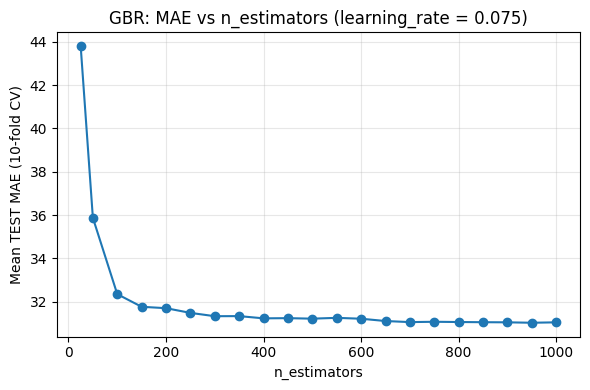

In [40]:
#picking best learning_rate from grid search
best_lr = gbr_grid.best_params_["learning_rate"]

#filtering grid results for that value
gbr_lr_slice = gbr_cv_df[gbr_cv_df["param_learning_rate"] == best_lr]

#extracting n_estimators and MAE, sorted by n_estimators
n_list_gbr = gbr_lr_slice["param_n_estimators"].astype(int)
mae_list_gbr = gbr_lr_slice["test_MAE"]

sort_order = np.argsort(n_list_gbr)
n_list_gbr = n_list_gbr.iloc[sort_order]
mae_list_gbr = mae_list_gbr.iloc[sort_order]

plt.figure(figsize=(6, 4))
plt.plot(n_list_gbr, mae_list_gbr, marker="o")
plt.title(f"GBR: MAE vs n_estimators (learning_rate = {best_lr})")
plt.xlabel("n_estimators")
plt.ylabel("Mean TEST MAE (10-fold CV)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()